**21127671 - Nguyễn Hoàng Phúc**

## **Steam Games Analysis Project**


### Import neccessary libraries

In [556]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import asyncio
import json
from typing import List, Dict
import requests
import aiohttp  # Async HTTP requests
import nest_asyncio # Nested async loops in Jupyter

## 1. Data Collection

### 1.1 SteamSpy API Data collection and processing

Since the official steam API returns all applications, not just games, and don't filter for spam apps, we will use SteamSpy as an alternative to get a quality list of games and information not found on the official API.


In [557]:
nest_asyncio.apply()

async def fetch_steamspy_page(session, page):
    # Fetch data from a single SteamSpy page
    base_url = 'https://steamspy.com/api.php'
    params = {'request': 'all', 'page': page}
    try:
        async with session.get(base_url, params=params) as response:
            if response.status == 200:
                return list((await response.json()).values())
            else:
                print(f"SteamSpy API error on page {page}: HTTP {response.status}")
                return []
    except Exception as e:
        print(f"SteamSpy API exception on page {page}: {e}")
        return []

async def fetch_all_steamspy_data(max_pages):
    # Fetch data from multiple SteamSpy pages asynchronously for better runtime
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_steamspy_page(session, page) for page in range(max_pages)]
        start_time = time.time()
        results = await asyncio.gather(*tasks)
        end_time = time.time()
        all_games = [game for page_games in results for game in page_games]
        print(f"Fetched {len(all_games)} games from SteamSpy in {end_time - start_time:.2f} seconds")
        return pd.DataFrame(all_games)

def get_steamspy_data(max_pages):
    # Manage asyncio event loop and call the fetch all function
    try:
        loop = asyncio.get_event_loop()
    except RuntimeError:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    return loop.run_until_complete(fetch_all_steamspy_data(max_pages))

# max_pages_steamspy = 10 # 1000 games per page
# steamspy_df = get_steamspy_data(max_pages_steamspy)
# steamspy_df.to_csv('steamspy_data.csv', index=False)
# print("Saved steamspy_data.csv")

### 1.2 Steam API Data Collection and Processing

Since most Vietnamese ISPs blocked Steam DNS, a VPN is required to scrape data from Steam.

In [558]:
def fetch_steam_store_app_details(app_id):
    # Fetch app details from Steam Store API
    url = f"https://store.steampowered.com/api/appdetails?appids={app_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()[str(app_id)]
        if data.get('success') and 'data' in data:
            return data['data']
        else:
            print(f"No data found for app ID {app_id} in Steam Store. Details: {data}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Steam Store API error for app ID {app_id}: {e}")
        return None

def fetch_all_steam_store_data(app_ids):
    # Fetch data for multiple apps from Steam Store API
    steamstore_data = []
    total_apps = len(app_ids)
    for i, app_id in enumerate(app_ids):
        data = get_steam_store_app_details(app_id)
        if data:
            steamstore_data.append({
                'appid': data.get('steam_appid'),
                'name': data.get('name'),
                'languages': data.get('supported_languages'),
                'metacritic': data.get('metacritic'),
                'genres': data.get('genres')
            })
        if (i + 1) % 100 == 0 or (i + 1) == total_apps:
            print(f"\rProcessed {i + 1}/{total_apps} games from Steam Store", end="", flush=True)
        time.sleep(1.5)  # API rate limits
    print() 
    return pd.DataFrame(steamstore_data)

#app_ids = steamspy_df['appid'].tolist()

# Because of Steam rate limits, 10000 games take 4 hours to fetch so function call is commented out

# steamstore_df = get_all_steam_store_data(app_ids)
# steamstore_df.to_csv("steamstore_data.csv", index=False)
# print("Saved steamstore_data.csv")

## 2. Data Preprocessing


In [559]:
steamspy_df = pd.read_csv('steamspy_data.csv')
steamstore_df = pd.read_csv('steamstore_data.csv')

steamspy_df.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
0,570,Dota 2,Valve,Valve,NaN,1920937,433766,0,"200,000,000 .. 500,000,000",40585,1304,910,812,0,0,0,643177
1,730,Counter-Strike: Global Offensive,Valve,Valve,NaN,7297590,1096059,0,"100,000,000 .. 200,000,000",32232,732,5620,313,0,0,0,969773
2,578080,PUBG: BATTLEGROUNDS,PUBG Corporation,"KRAFTON, Inc.",NaN,1447873,1011012,0,"50,000,000 .. 100,000,000",22327,847,5729,288,0,0,0,322362
3,1172470,Apex Legends,Respawn,Electronic Arts,NaN,651498,310966,0,"50,000,000 .. 100,000,000",9613,464,726,144,0,0,0,78658
4,440,Team Fortress 2,Valve,Valve,NaN,995159,128852,0,"50,000,000 .. 100,000,000",11888,1401,354,306,0,0,0,41811


In [560]:
steamstore_df.head()

,appid,name,languages,metacritic,genres
0,570,Dota 2,"Bulgarian, Czech, Danish, Dutch, English<stron...","{'score': 90, 'url': 'https://www.metacritic.c...","[{'id': '1', 'description': 'Action'}, {'id': ..."
1,730,Counter-Strike 2,"Czech, Danish, Dutch, English<strong>*</strong...",NaN,"[{'id': '1', 'description': 'Action'}, {'id': ..."
2,578080,PUBG: BATTLEGROUNDS,"English, Korean, Simplified Chinese, French, G...",NaN,"[{'id': '1', 'description': 'Action'}, {'id': ..."
3,1172470,Apex Legends™,"English<strong>*</strong>, French<strong>*</st...","{'score': 88, 'url': 'https://www.metacritic.c...","[{'id': '1', 'description': 'Action'}, {'id': ..."
4,440,Team Fortress 2,"English<strong>*</strong>, Danish, Dutch, Finn...","{'score': 92, 'url': 'https://www.metacritic.c...","[{'id': '1', 'description': 'Action'}, {'id': ..."


In [561]:
merged_df = pd.merge(steamspy_df, steamstore_df, on=['appid', 'name'], how='inner')
print(f"Number of games in merged_df: {merged_df.shape[0]}")
print(merged_df.isnull().sum())
merged_df = merged_df.dropna(subset=['languages','metacritic','genres'])
print(f"Number of games in merged_df after dropping : {merged_df.shape[0]}")

Number of games in merged_df: 9373
appid                 0
name                  0
developer            31
publisher            14
score_rank         9371
positive              0
negative              0
userscore             0
owners                0
average_forever       0
average_2weeks        0
median_forever        0
median_2weeks         0
price                 0
initialprice          0
discount              0
ccu                   0
languages             2
metacritic         6894
genres               26
dtype: int64
Number of games in merged_df after dropping : 2478


In [562]:
# Function to extract the Metacritic score from json string
def extract_metacritic_score(metacritic):
    if pd.isnull(metacritic):
        return None
    try:
        if isinstance(metacritic, str):
            metacritic = eval(metacritic)
        return metacritic.get('score')
    except:
        return None

# Function to count the number of languages
def count_languages(languages_str):
    if pd.isnull(languages_str) or not isinstance(languages_str, str):
        return 0
    languages_str = re.sub('<[^<]+?>', '', languages_str)
    return len(languages_str.split(','))

# Extract genres into a list
def extract_genres(genre_list):
    if pd.isnull(genre_list):
        return []
    try:
        # Convert string representation to list if necessary
        if isinstance(genre_list, str):
            genre_list = eval(genre_list)
        return [genre['description'].lower() for genre in genre_list]
    except:
        return []
    
# Apply the functions
merged_df['metacritic'] = merged_df['metacritic'].apply(extract_metacritic_score)
merged_df['languages'] = merged_df['languages'].apply(count_languages)

merged_df['genre_list'] = merged_df['genres'].apply(extract_genres)
# List of top genres to create boolean columns for
top_genres = ['indie', 'action', 'casual', 'adventure', 'simulation',
              'rpg', 'strategy', 'sports', 'racing', 'massively multiplayer']
# Create boolean columns for each top genre
for genre in top_genres:
    merged_df[f'genre_{genre}'] = merged_df['genre_list'].apply(lambda x: int(genre in x))
    
selected_columns = ['appid', 'name', 'metacritic', 'median_forever', 'price', 'languages']
selected_columns += [f'genre_{genre}' for genre in top_genres]
# Create the final DataFrame
processed_df = merged_df[selected_columns]
processed_df.rename(columns={'median_forever': 'median_playtime'}, inplace=True)

C:\Users\PHUC\AppData\Local\Temp\ipykernel_27472\759875255.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df.rename(columns={'median_forever': 'median_playtime'}, inplace=True)


## 3. Exploratory Data Analysis

In [563]:
processed_df.head()

,appid,name,metacritic,median_playtime,price,languages,genre_indie,genre_action,genre_casual,genre_adventure,genre_simulation,genre_rpg,genre_strategy,genre_sports,genre_racing,genre_massively multiplayer
0,570,Dota 2,90,910,0,28,0,1,0,0,0,0,1,0,0,0
2,440,Team Fortress 2,92,354,0,27,0,1,0,0,0,0,0,0,0,0
6,271590,Grand Theft Auto V,96,6719,2430,13,0,1,0,1,0,0,0,0,0,0
7,550,Left 4 Dead 2,89,530,200,28,0,1,0,0,0,0,0,0,0,0
8,252490,Rust,69,2679,3999,25,1,1,0,1,0,1,0,0,0,1


In [564]:
print(f"Number of games in processed_df: {processed_df.shape[0]}")


Number of games in processed_df: 2478


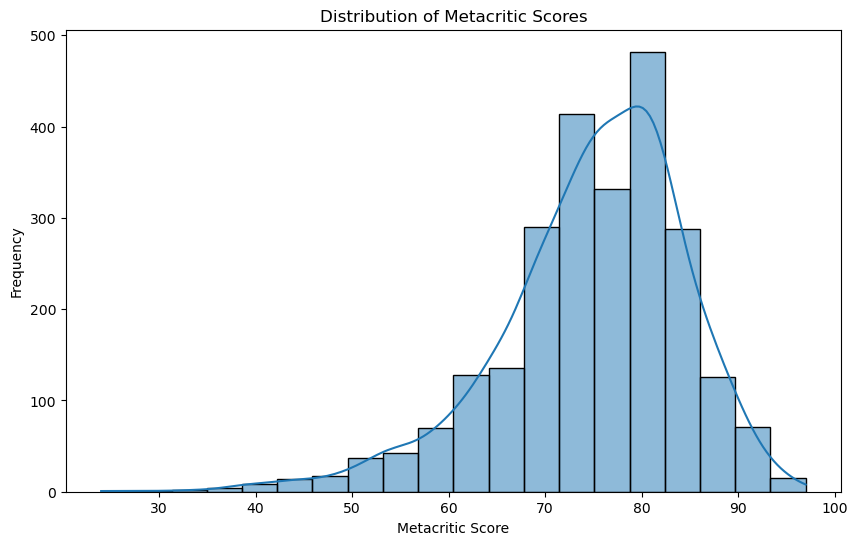

In [ ]:
# Histogram of Metacritic scores
plt.figure(figsize=(10, 6))
sns.histplot(processed_df['metacritic'], bins=20, kde=True)
plt.title('Distribution of Metacritic Scores')
plt.xlabel('Metacritic Score')
plt.ylabel('Frequency')
plt.show()

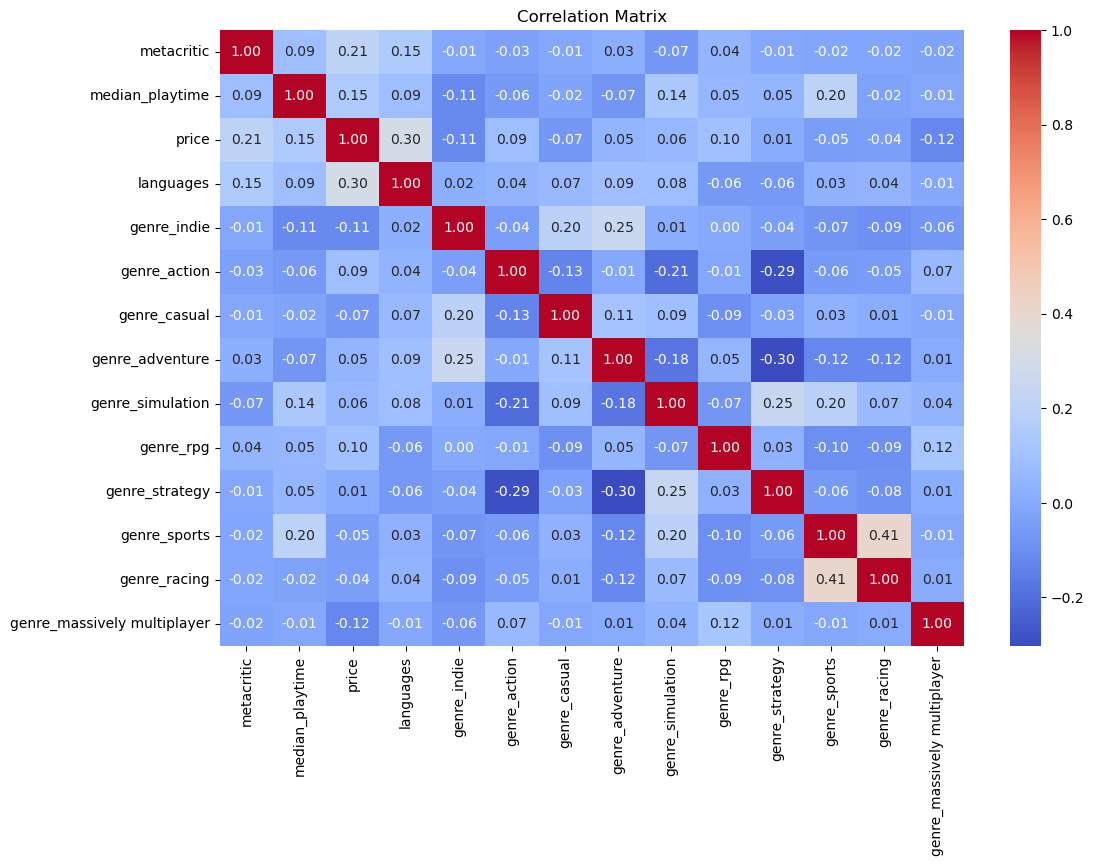

In [566]:
# Compute correlation matrix
corr_matrix = processed_df.drop(columns=['appid', 'name']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

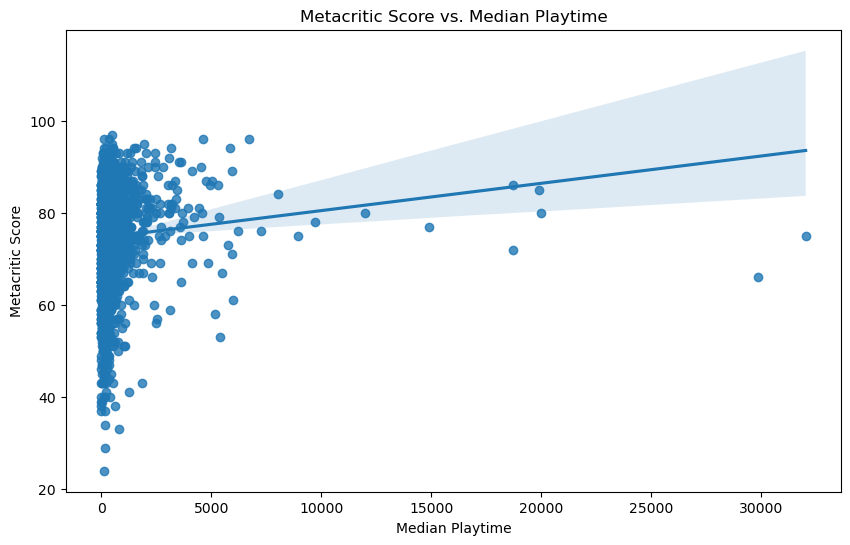

In [567]:
plt.figure(figsize=(10, 6))
sns.regplot(x=processed_df['median_playtime'], y='metacritic', data=processed_df)  # Log transformation
plt.xlabel('Median Playtime')
plt.ylabel('Metacritic Score')
plt.title('Metacritic Score vs. Median Playtime')
plt.show()

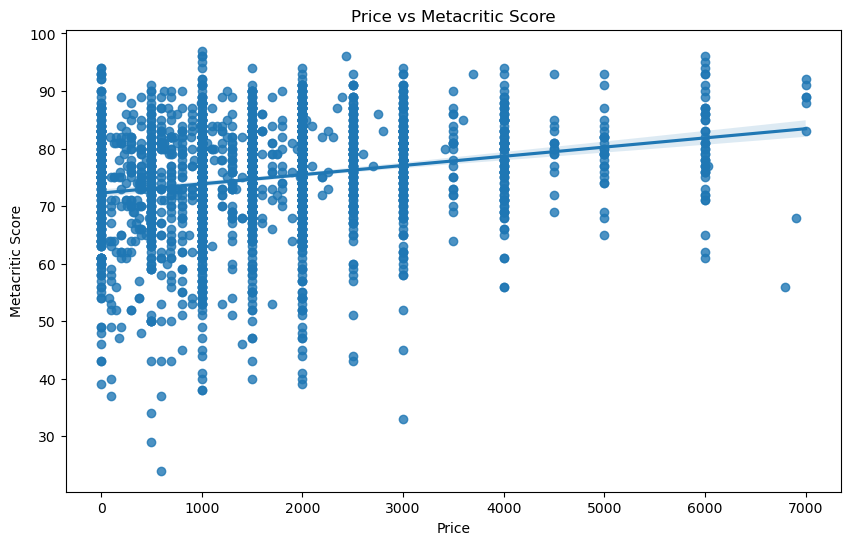

In [568]:
# Scatter plot of Price vs Metacritic Score
plt.figure(figsize=(10, 6))
sns.regplot(x='price', y='metacritic', data=processed_df)
plt.title('Price vs Metacritic Score')
plt.xlabel('Price')
plt.ylabel('Metacritic Score')
plt.show()


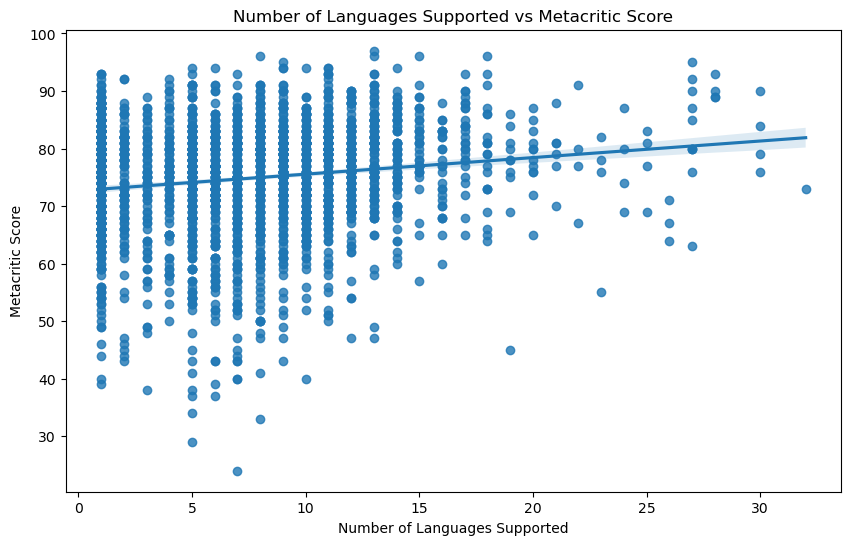

In [569]:
# Scatter plot of Number of Languages vs Metacritic Score
plt.figure(figsize=(10, 6))
sns.regplot(x='languages', y='metacritic', data=processed_df)
plt.title('Number of Languages Supported vs Metacritic Score')
plt.xlabel('Number of Languages Supported')
plt.ylabel('Metacritic Score')
plt.show()


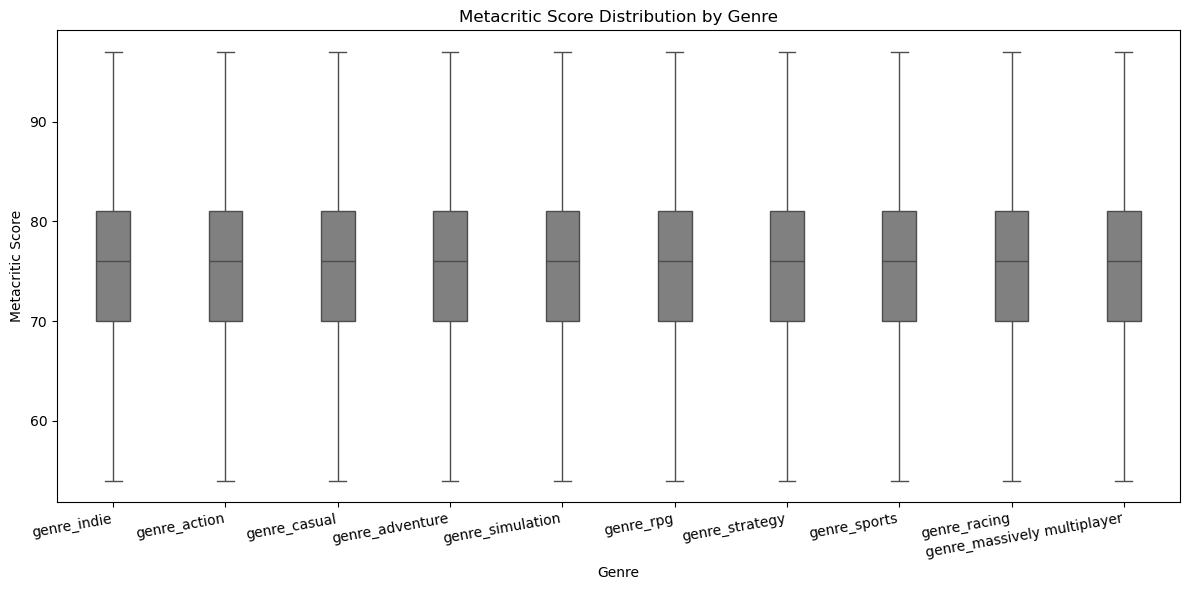

In [570]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='metacritic', data=processed_df.melt(id_vars=['metacritic'], 
                                                               value_vars=[f'genre_{genre}' for genre in top_genres],
                                                               var_name='genre', value_name='present'),
            color='gray', showfliers=False, width=0.3) 
plt.xticks(rotation=10, ha='right')
plt.xlabel('Genre')
plt.ylabel('Metacritic Score')
plt.title('Metacritic Score Distribution by Genre')
plt.tight_layout()
plt.show()


### Analysis of the data
- There is no strong correlation in the dataset
- median_forever is by far the most skewed feature -> normalization by log transformation before data modelling

In [571]:
# Create an explicit copy of the DataFrame
processed_df = processed_df.copy()

# Calculate median and replace zeros
median_of_median_playtime = int(processed_df[processed_df['median_playtime'] > 0]['median_playtime'].median())
processed_df.loc[processed_df['median_playtime'] == 0, 'median_playtime'] = median_of_median_playtime

# Convert to float first, then apply log transformation
processed_df['median_playtime'] = processed_df['median_playtime'].astype('float64')
processed_df['median_playtime'] = np.log1p(processed_df['median_playtime'])

# Rename the column
processed_df = processed_df.rename(columns={'median_playtime': 'log_median_playtime'})

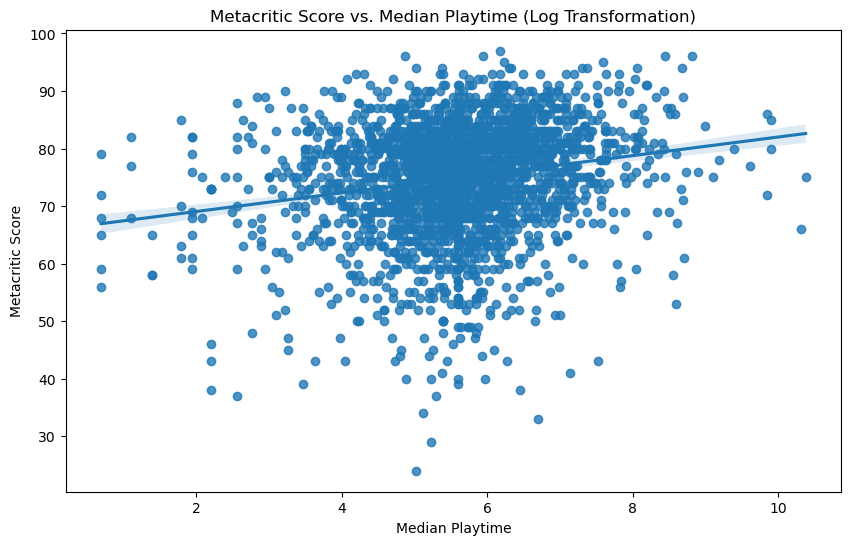

In [572]:
plt.figure(figsize=(10, 6))
sns.regplot(x=processed_df['log_median_playtime'], y='metacritic', data=processed_df)
plt.xlabel('Median Playtime')
plt.ylabel('Metacritic Score')
plt.title('Metacritic Score vs. Median Playtime (Log Transformation)')
plt.show()